In [738]:
import seaborn as sns
import pandas as pd
import numpy as np 
import torch 
import torch.nn as nn
import tensorflow as tf
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from hmmlearn import hmm

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple GPU with Metal backend.")
else:
    device = torch.device("cpu")
    print("Using CPU.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using Apple GPU with Metal backend.


Data Preprocessing
- rows = EEG value at time (t)
- column = electode (e) 
- input (X_t) = [x_1, x_2,...,x_t] x_t = R^19 vector 
- Normalize the data per electrode channel Z-score prefered as z-scored keeps the spread more consistent and allows the EM to converge faster

train 31000
val 31000
test 31000
train mean: [-0.19180635 -0.30276135 -0.20970165 -0.13792462 -0.18441475 -0.19261662
 -0.06450119 -0.05520229 -0.15954249 -0.15056066 -0.04988986  0.10459939
 -0.00710789 -0.04441872  0.01081588  0.12752108 -0.12197463 -0.25482735
 -0.05122908]
val mean:   [-0.09519834 -0.07147053  0.01444951 -0.02768624 -0.11677041  0.0003031
  0.01344289  0.01706495  0.01417257  0.02432989 -0.01371452 -0.01592968
  0.10161819 -0.00845236  0.01690931 -0.01676986 -0.00261203 -0.01127219
 -0.05618486]
test mean:  [-0.01712139  0.0927911   0.03812027  0.02813464  0.00101296  0.14193436
  0.05491151  0.02839297  0.14091692  0.05535593 -0.01468301 -0.0483127
  0.02606873 -0.05696428  0.21045129  0.12643414 -0.00230289  0.04322447
  0.03997813]
train std: [16.13005424 12.40943091 12.94144697 12.31769951 12.98190798 12.64384348
 11.58758268 13.32442023 11.66466026 11.48751278 10.23136293 10.84900323
 10.63529591 11.41944846 12.85473707 16.66030743 12.3862097  13.32500988
 10.

/var/folders/h0/8gnjc7295ds0nvrdwysmv4n00000gn/T/ipykernel_69422/2453167797.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


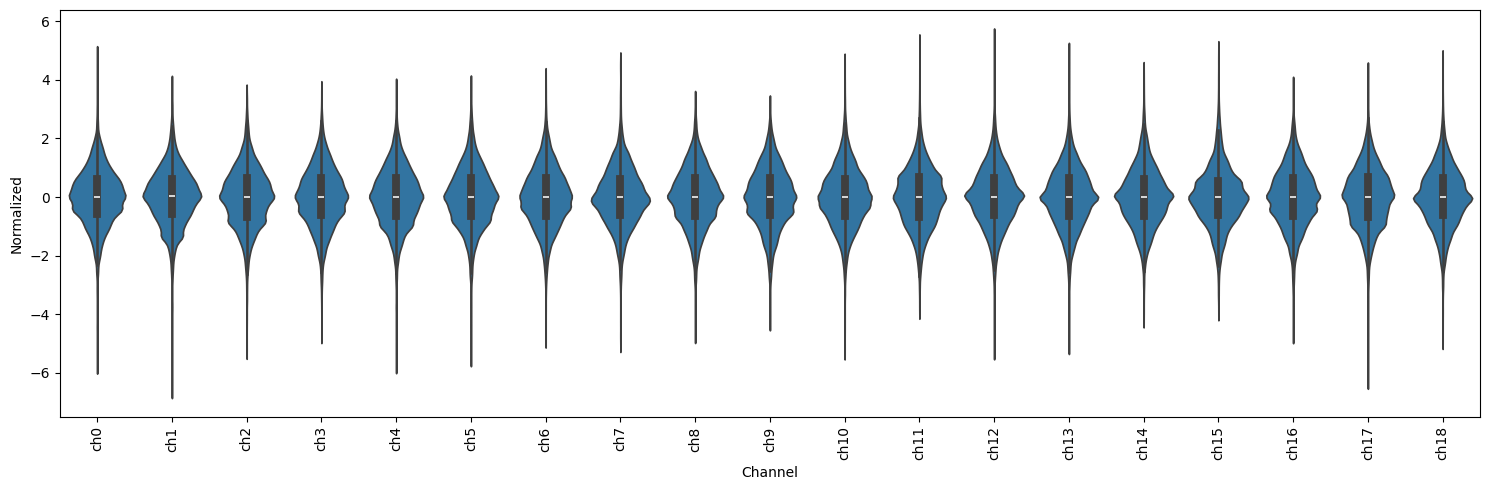

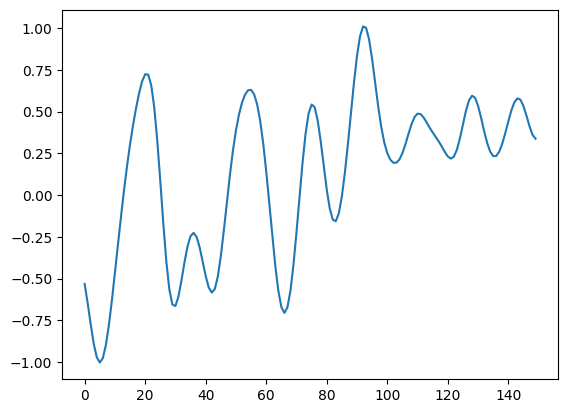

<Figure size 1900x1000 with 0 Axes>

In [739]:
#Split data
train_data = data = np.loadtxt('/Users/minwoongyoon/Documents/T-GAN/Data/s00.csv', delimiter= ",") 
val_data = np.loadtxt('/Users/minwoongyoon/Documents/T-GAN/Data/s03.csv', delimiter= ",")
test_data = np.loadtxt('/Users/minwoongyoon/Documents/T-GAN/Data/s02.csv', delimiter= ",")

print("train", len(train_data))
print("val", len(val_data))
print("test", len(test_data))

#means and stdevs
x = np.arange(data.shape[0])
train_mean = train_data.mean(axis=0)
train_std = train_data.std(axis=0)
print("train mean:", train_data.mean(axis=0))
print("val mean:  ", val_data.mean(axis=0))
print("test mean: ", test_data.mean(axis=0))

print("train std:", train_data.std(axis=0))
print("val std:  ", val_data.std(axis=0))
print("test std: ", test_data.std(axis=0))

#normalizations values
train_data = (train_data - train_mean)/train_std
val_data = (val_data - train_mean)/ train_std
test_data = (test_data - train_mean)/ train_std

#as tensors
train_tensor = torch.from_numpy(train_data.astype(np.float32))
val_tensor = torch.from_numpy(val_data.astype(np.float32))
test_tensor = torch.from_numpy(test_data.astype(np.float32))

#channels
channel_names = [f"ch{i}" for i in range(train_data.shape[1])]
df = pd.DataFrame(train_data, columns=channel_names)

#plotting normalized
df_long = df.melt(var_name="Channel", value_name="Normalized")
plt.figure(figsize=(15, 5))
ax = sns.violinplot(data=df_long, x="Channel", y="Normalized")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

#saving 
np.savetxt("/Users/minwoongyoon/Documents/T-GAN/Data/train_data.csv", train_data, delimiter=",")

#1 electrode plotting
plt.plot(x[:150], train_tensor[:150, 4], label=f"electrode {2}")
plt.figure(figsize=(19,10))
plt.show()



Tumbling window  
standard EEG sampling rate = 512 Hz 
f = 1/(T)
31,000/60s = 516 ~ 512Hz (samples per seconds)
window: 
512 * sec = sample_nums
if we assume sec = 512 * 0.1 ~ 50 samples per window 
- to smooth the noise and reduce the sequence length even more 

(310, 19)
[[-0.84298052 -0.16257979  0.22892475 -0.01081562  0.00596968  0.31445024
   0.71336476 -0.61327991  0.01670987 -0.1301435   0.33432056 -0.03326376
  -0.01851699 -0.25773813  0.24611844 -0.15891236  0.01709384  0.94202249
   0.46082661]]


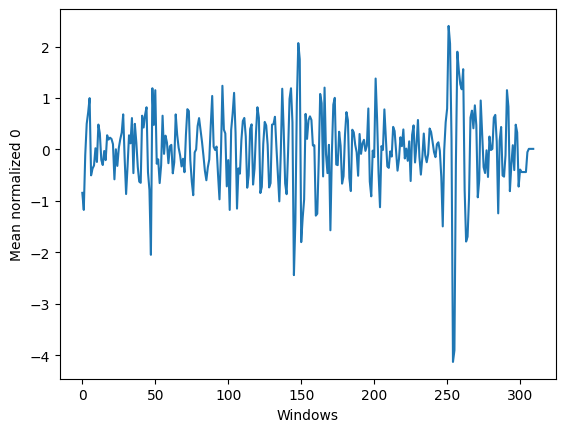

In [740]:

def Tumbling_window(array, win_size):
    M, N = array.shape
    win_nums = M // win_size #divide 31000 M(row)// window_size
    cut_window = array[:win_nums * win_size] 
    window = cut_window.reshape(win_nums, win_size, N) #from 31000X19 -> 31000/200, X win_size(60) X 19
    return window.mean(axis=1)

train_obs = Tumbling_window(train_data, win_size= 100) #win_size = hyperparameter 
val_obs = Tumbling_window(val_data, win_size= 100)
test_obs = Tumbling_window(test_data, win_size= 100)

print(train_obs.shape)

print(train_obs[:1, 0:19])
plt.plot(train_obs[:, 0])
plt.xlabel("Windows")
plt.ylabel("Mean normalized 0")
plt.show()


Gaussian HMM 

-hidden state: Z1...Z_t
-transition: A(z, z') = P(z_t+1 | z_t )
-Prior: P(z_1 = k)
-Emission: x_t| z_t = z_1 ~ N(u_k, cov_k)
-EM(Baum-Welch) algo- > parameters[alpha, beta, gamma, u_k, cov_k, A(z,z')]
-Covariance = diagonal (assume xt is conditionally independent given z)




P(z_t=k|X,theta) (310, 3)
z-state values: [0.40293179 0.35812531 0.2389429 ]
z: (310,)


         1   -4298.72635417             +nan
         2   -3316.24949529    +982.47685888
         3   -3180.96792415    +135.28157113
         4   -3171.96411412      +9.00381003
         5   -3165.64576494      +6.31834918
         6   -3162.08479178      +3.56097316
         7   -3160.78446839      +1.30032339
         8   -3160.03181432      +0.75265407
         9   -3159.58484544      +0.44696888
        10   -3159.28426971      +0.30057573
        11   -3159.03781673      +0.24645298
        12   -3158.80256936      +0.23524737
        13   -3158.55383579      +0.24873356
        14   -3158.27803505      +0.27580074
        15   -3157.97903239      +0.29900267
        16   -3157.67814779      +0.30088459
        17   -3157.39338382      +0.28476397
        18   -3157.12368132      +0.26970250
        19   -3156.85468668      +0.26899465
        20   -3156.56715773      +0.28752894
        21   -3156.24338040      +0.32377733
        22   -3155.87986481      +0.36351559
        23

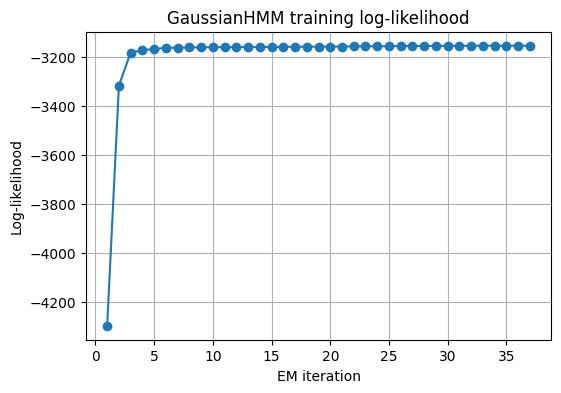

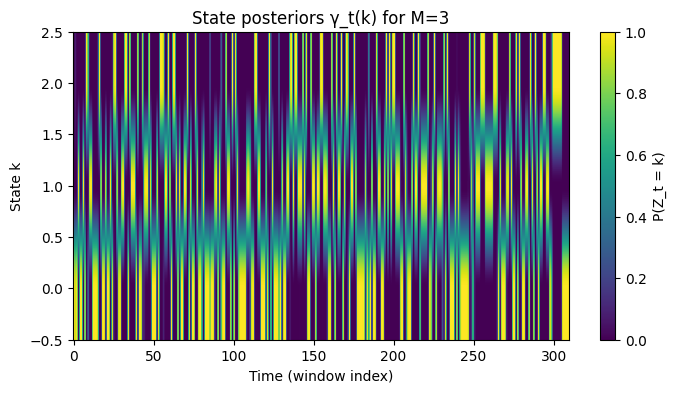

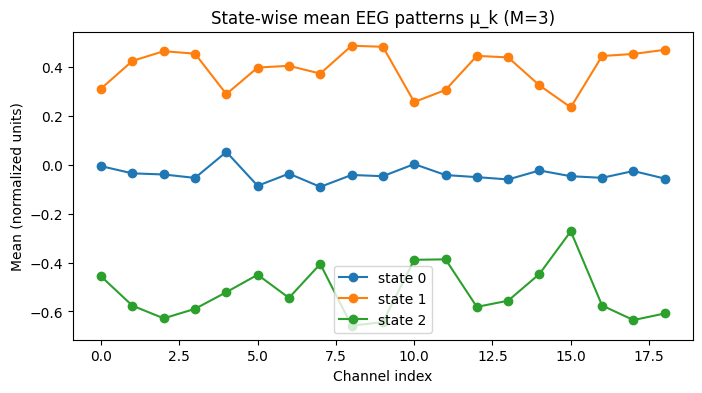

train: -10.170896772927035
val  : -7.194726958079621
test : -11.70244105391656



In [741]:
M = 3

model = hmm.GaussianHMM(
    n_components = M, 
    covariance_type = "diag",
    n_iter=40,
    verbose = True,
    random_state = 0,
    algorithm = 'viterbi')

#Training lnp(x_t|theta)
model.fit(train_obs) #EM algorithm 
#gammat(k) = p(x,z_t=k|x, theta)
log_train, gamma_train = model.score_samples(train_obs)
print("P(z_t=k|X,theta)",gamma_train.shape)
print("z-state values:", gamma_train.mean(axis=0)) #mean values through all t steps

#validation set
log_val,  gamma_val  = model.score_samples(val_obs)
log_test, gamma_test = model.score_samples(test_obs)

z_states = model.predict(train_obs) # 
print("z:", z_states.shape)

#parameters
'''
print("prior:", model.startprob_)
print("A:", model.transmat_)
print("μ:", model.means_)  
print("Σ:", model.covars_) 
'''

#log-likelihood graph 
t = np.arange(train_obs.shape[0])

ll_history = np.array(model.monitor_.history)  # list -> numpy
iters = np.arange(1, len(ll_history) + 1)

plt.figure(figsize=(6, 4))
plt.plot(iters, ll_history, marker="o")
plt.xlabel("EM iteration")
plt.ylabel("Log-likelihood")
plt.title("GaussianHMM training log-likelihood")
plt.grid(True)
plt.show()

#gamma heatmap
plt.figure(figsize=(8, 4))
plt.imshow(gamma_train.T, aspect="auto", origin="lower")
plt.ylabel("State k")
plt.xlabel("Time (window index)")
plt.colorbar(label="P(Z_t = k)")
plt.title("State posteriors γ_t(k) for M=3")
plt.show()

M = model.n_components
channels = np.arange(train_obs.shape[1])  # 0..18

#mean plots
plt.figure(figsize=(8, 4))
for k in range(M):
    plt.plot(channels, model.means_[k], marker='o', label=f"state {k}")
plt.xlabel("Channel index")
plt.ylabel("Mean (normalized units)")
plt.title("State-wise mean EEG patterns μ_k (M=3)")
plt.legend()
plt.show()

#validation 
def avg_loglik(model, X):
    return model.score(X) / len(X)  # per time step
train_ll = avg_loglik(model, train_obs)
val_ll   = avg_loglik(model, val_obs)
test_ll  = avg_loglik(model, test_obs)

print("train:", train_ll)
print("val  :", val_ll)
print("test :", test_ll)

print()

This plot shows that there are 3 different modes of the brain activity: 
- higher and lower levels of engagement -> state 1 highest and state 2 lowest  
- groups of electrodes 
- changing the cov_type from 'full' to 'diag' made the validation more closely aligned with train which shows there is no overfitting. 

Gan for forecasting 
- Create class for predicting the window given the past window  
- we use the posterior state probabiltiies p(zt=k |Xt, parameters) as inputs 
- Sliding window (stride = 1) of our tumbling window 
- y = x_{t+1} for predicted value given the sequence length 
Hyperparameters
- seq_len(L): # of time step in one sliding window
- Noise dim
- batch_size (B): # of different context windows in one training step


In [742]:
#hyper parameters
seq_len = 30 
noise_dim = 32 
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#preprocess the dataset
#goal: make the gammma, noise, and raw data into input for generator
class EegHmmDataset(Dataset):
    def __init__(self, win_array, gamma_array, seq_len):

        #make gamma and obs_x as arrays to call indexes 
        win_array   = np.asarray(win_array,   dtype=np.float32) #x_t
        gamma_array = np.asarray(gamma_array, dtype=np.float32) #g_t

        #make sure they have the same length t
        win_seq = win_array.shape[0] #x_t (B=t, 19) 
        g_seq = gamma_array.shape[0] #g_t (B, 3)
        max_length = min(win_seq, g_seq)

        if win_seq != g_seq:
            print("x and g not same lengths!")

        win_array = win_array[:max_length] # dim = B, 19
        gamma_array = gamma_array[:max_length] #dim = B, 3

        #x= tensored(x_t), g = tensored(g_t), L = context length, T = max_length, N = len of train data   
        self.x = torch.from_numpy(win_array).float() #310
        self.g = torch.from_numpy(gamma_array).float() #310
        self.L = seq_len
        self.T = max_length
        self.N = self.T - self.L # numbs of sliding windows 

    def __len__(self):
        return self.N

    def __getitem__(self, index): #sliding window to get predicted x_{t+1}
        #context for a specific interval 
        context_x = self.x[index: index + self.L] #for our context of t: t+L-1
        context_gamma = self.g[index: index + self.L]  #same for gamma 
        #y dim = [t+L]
        y = self.x[index + self.L] #y = # at end of sequence 
        return context_x, context_gamma, y

#training set
#turning to array is redundant - more helpful to understand
obs_x = np.asarray(train_obs, dtype=np.float32)  # (T, x_dim)
gamma_g = np.asarray(gamma_train, dtype=np.float32)  # (T, g_dim)

#validation set
obs_x_val = np.asarray(val_obs, dtype=np.float32)
gamma_val_np = np.asarray(gamma_val, dtype=np.float32)

x_dim = obs_x.shape[1] #19
print(x_dim)
g_dim = gamma_g.shape[1] #3

#batch (context_x, context_gamma) = ctx_x, ctx_g
train_dataset = EegHmmDataset(obs_x, gamma_g, seq_len)
loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = EegHmmDataset(obs_x_val,   gamma_val_np,   seq_len)
val_loader = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)


19


Generator 
for t= 1 time step:
-> x_t => 19 values, and g_t = 3 values -
-> flatten(noise_z, x_t, g_t)  
-> vector of input (Dimension h) =  noise_dim + (seq_len * col(x_t)) + (seq_len * col(g_t))

In [754]:
class Generator(nn.Module):
    def __init__(self, gen_layer_sizes, noise_dim, seq_len, x_dim, g_dim):
        super().__init__()

        self.noise_dim = noise_dim
        self.seq_len = seq_len
        self.x_dim = x_dim
        self.g_dim = g_dim

        #input dimension 
        in_dim = noise_dim + seq_len * (x_dim + g_dim) # input_dim: [h, 1], 

        #W_3(ReLU(W_2(ReLu(W_1*h + b))))
        self.model = nn.Sequential(
            nn.Linear(in_dim, gen_layer_sizes[0]), #W_1:[256,h]  
            nn.ReLU(inplace=True), #Relu replaces negative [256,1]
            nn.Linear(gen_layer_sizes[0], gen_layer_sizes[1]), #W_2: [256,256]
            nn.ReLU(inplace=True), #[256,1]
            nn.Linear(gen_layer_sizes[1], x_dim) #W_3: [19, 256] -> [19,1]
        )

    def forward(self, z, ctx_x, ctx_g):
        B = ctx_x.size(0) #batch size 
        x_flat = ctx_x.view(B, -1) 
        g_flat = ctx_g.view(B, -1)

        h = torch.cat([z, x_flat, g_flat], dim=1) #concat the dimension z= noise, x_t, g_t into a vector 
        out = self.model(h) #receive output from generator with h as input. 
        return out
        
'''
print(ctx_x)
'''


'\nprint(ctx_x)\n'

Discriminator
- utilize leaky RELU to avoid units being stuck at 0 for all inputs 

In [755]:
class Discriminator(nn.Module):
    def __init__(self, disc_layer_sizes, seq_len, x_dim, g_dim):
        super().__init__()

        self.seq_len = seq_len
        self.x_dim = x_dim
        self.g_dim = g_dim

        #input into the discrimnator the x, g, noise z
        in_dim = seq_len * (x_dim + g_dim) + x_dim  # [ctx_x, ctx_g, future_x]

        self.model = nn.Sequential(
            nn.Linear(in_dim, disc_layer_sizes[0]), #(B, 256)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3), #overfitting
            
            nn.Linear(disc_layer_sizes[0], disc_layer_sizes[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Linear(disc_layer_sizes[1], disc_layer_sizes[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(disc_layer_sizes[2], 1), #(B, 1)
            # BCEWithLogitsLoss -> no sigmoid here
        )

    def forward(self, ctx_x, ctx_g, fut_x):
        B = ctx_x.size(0)
        x_flat = ctx_x.view(B, -1) 
        g_flat = ctx_g.view(B, -1) 

        h = torch.cat([x_flat, g_flat, fut_x], dim=1)   #(B, in_dim)
        out = self.model(h)
        return out   # keep shape (B, 1), don't squeeze
    


In [756]:
#more parameters 
gen_sizes = [256, 128]
disc_sizes = [256, 256, 256]

G = Generator(gen_sizes, noise_dim, seq_len, x_dim, g_dim).to(device)
D = Discriminator(disc_sizes, seq_len, x_dim, g_dim).to(device)

Train w/ BCE 
and MSE for predicted 

In [757]:
bce = nn.BCEWithLogitsLoss()
mse = nn.MSELoss()
#adam optimizer
g_opt = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.9), weight_decay = 1e-4) #2 hyperparameters betas for gradients 0.5 affects momentum 
d_opt = torch.optim.Adam(D.parameters(), lr=0.005, betas=(0.5, 0.9), weight_decay = 1e-4)

lambda_mse = 0.05
epochs = 100

for epoch in range(1, epochs + 1):
    G.train()
    D.train()
    #initialize lossese 
    d_loss_sum = 0.0
    adv_loss_sum = 0.0
    g_loss_sum = 0.0
    mse_sum = 0.0
    n_batches = 0

    for ctx_x, ctx_g, y in loader: #y = realdata 
        ctx_x = ctx_x.to(device)
        ctx_g = ctx_g.to(device)
        y = y.to(device)
        B = ctx_x.size(0)

        #Train Discriminator
        
        #get random noise 
        z = torch.randn(B, noise_dim, device=device)
        #Generator ouputs fake  
        with torch.no_grad():
            fake_y = G(z, ctx_x, ctx_g) #generate noise, x, and gamma

        #real labels vs fake labels 1 vs 0
        real_labels = torch.ones(B, 1, device=device)
        fake_labels = torch.zeros(B, 1, device=device)

        #turn off discriminator optimizer
        d_opt.zero_grad()

        logits_real = D(ctx_x, ctx_g, y) #compare against real values vs fake 
        logits_fake = D(ctx_x, ctx_g, fake_y)

        #get the loss values of real vs fake 
        loss_D_real = bce(logits_real, real_labels)
        loss_D_fake = bce(logits_fake, fake_labels)
        
        #total loss of dis
        loss_D = loss_D_real + loss_D_fake
        loss_D.backward() #gradients
        
        #updating parameters with gradients
        d_opt.step()

        #Update Generator again to fool the discriminator 
        z = torch.randn(B, noise_dim, device=device)
        
        g_opt.zero_grad()
        gen_y = G(z, ctx_x, ctx_g)# generating new prediction x_t
        logits_fake_for_G = D(ctx_x, ctx_g, gen_y)  # (B, 1)

        adv_loss = bce(logits_fake_for_G, real_labels)  # fooling the discriminator 
        pred_mse = mse(gen_y, y) # forecasting loss
        loss_G   = adv_loss + lambda_mse * pred_mse

        loss_G.backward()
        g_opt.step()

        adv_loss_sum += adv_loss.item()
        d_loss_sum += loss_D.item()
        g_loss_sum += loss_G.item()
        mse_sum    += pred_mse.item()
        n_batches  += 1

    #validation
    G.eval()
    D.eval()

    val_d_loss_sum = 0.0
    val_adv_loss_sum = 0.0
    val_mse_sum = 0.0
    val_n_batches = 0

    with torch.no_grad():
        for ctx_x, ctx_g, y in val_loader:
            ctx_x = ctx_x.to(device)
            ctx_g = ctx_g.to(device)
            y = y.to(device)
            B = ctx_x.size(0)

            real_labels = torch.ones(B, 1, device=device)
            fake_labels = torch.zeros(B, 1, device=device)

            z = torch.randn(B, noise_dim, device=device)
            fake_y = G(z, ctx_x, ctx_g)

            logits_real = D(ctx_x, ctx_g, y)
            logits_fake = D(ctx_x, ctx_g, fake_y)

            loss_D_real = bce(logits_real, real_labels)
            loss_D_fake = bce(logits_fake, fake_labels)
            loss_D_val = loss_D_real + loss_D_fake

            adv_loss_val = bce(logits_fake, real_labels)
            mse_val = mse(fake_y, y)

            val_d_loss_sum += loss_D_val.item()
            val_adv_loss_sum += adv_loss_val.item()
            val_mse_sum += mse_val.item()
            val_n_batches += 1

    val_D = val_d_loss_sum / val_n_batches
    val_adv = val_adv_loss_sum / val_n_batches
    val_MSE = val_mse_sum / val_n_batches

    #training epochs
    print(f"Epoch {epoch:02d} | "
          f"adv_loss={adv_loss_sum/n_batches:.4f} | "
          f"D_loss={d_loss_sum/n_batches:.4f} | "
          f"G_loss={g_loss_sum/n_batches:.4f} | "
          f"MSE={mse_sum/n_batches:.4f}")
    
    #validation epochs
    print(
        f"Epoch {epoch:02d} | "
        f"val_adv={val_adv:.4f}  | val_D={val_D:.4f}  | _____________ | val_MSE={val_MSE:.4f}"
    )
    baseline_sqs = []

#for cross checking the baseline MSE for validation set
for ctx_x, ctx_g, y in val_dataset:
    # ctx_x: (L, x_dim), y: (x_dim,)
    last_x = ctx_x[-1] # x_{t-1}
    mse_val = ((last_x - y)**2).mean().item()
    baseline_sqs.append(mse_val)

baseline_val_mse = np.mean(baseline_sqs)
print("Baseline val MSE (persistence):", baseline_val_mse)
print("Model val MSE (GAN):", val_MSE)  # use your logged val_MSE



Epoch 01 | adv_loss=0.7572 | D_loss=1.4399 | G_loss=0.7735 | MSE=0.3261
Epoch 01 | val_adv=0.5580  | val_D=1.4170  | _____________ | val_MSE=0.2118
Epoch 02 | adv_loss=0.7291 | D_loss=1.4046 | G_loss=0.7449 | MSE=0.3163
Epoch 02 | val_adv=0.7917  | val_D=1.3940  | _____________ | val_MSE=0.2109
Epoch 03 | adv_loss=0.7165 | D_loss=1.4001 | G_loss=0.7323 | MSE=0.3152
Epoch 03 | val_adv=0.7866  | val_D=1.3883  | _____________ | val_MSE=0.2094
Epoch 04 | adv_loss=0.7869 | D_loss=1.3433 | G_loss=0.8021 | MSE=0.3046
Epoch 04 | val_adv=0.9500  | val_D=1.2433  | _____________ | val_MSE=0.2088
Epoch 05 | adv_loss=0.9268 | D_loss=1.2007 | G_loss=0.9414 | MSE=0.2925
Epoch 05 | val_adv=0.8712  | val_D=1.1409  | _____________ | val_MSE=0.2095
Epoch 06 | adv_loss=1.0216 | D_loss=1.1889 | G_loss=1.0362 | MSE=0.2905
Epoch 06 | val_adv=1.1684  | val_D=1.0307  | _____________ | val_MSE=0.2104
Epoch 07 | adv_loss=1.1923 | D_loss=0.9960 | G_loss=1.2067 | MSE=0.2884
Epoch 07 | val_adv=1.4142  | val_D=1.067

One-Step Prediction 
- all real []

all_real: (280, 19) all_fake: (280, 19)


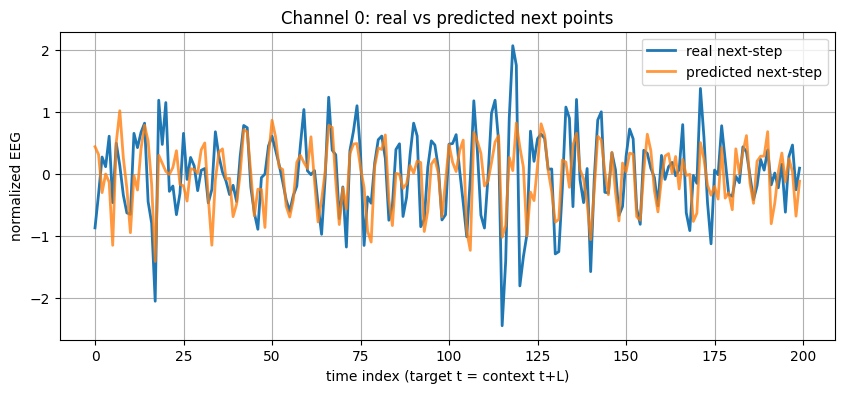

In [758]:
#predicting every one step
G.eval()

all_real = []
all_fake = []

with torch.no_grad():
    for i in range(len(train_dataset)):
        ctx_x, ctx_g, y = train_dataset[i] # ctx_x: (L=30, x_dim=19), y: (x_dim,)

        # add batch dimension -> (1, L, x_dim) / (1, L, g_dim)
        ctx_x = ctx_x.unsqueeze(0).to(device)
        ctx_g = ctx_g.unsqueeze(0).to(device)
        y = y.unsqueeze(0).to(device)

        z = torch.randn(1, noise_dim, device=device)
        y_hat = G(z, ctx_x, ctx_g) # (1, x_dim)
        all_real.append(y.cpu().numpy())
        all_fake.append(y_hat.cpu().numpy())  # (1, x_dim)

# stack -> (N, x_dim)
all_real = np.concatenate(all_real, axis=0)
all_fake = np.concatenate(all_fake, axis=0)

print("all_real:", all_real.shape, "all_fake:", all_fake.shape)

ch = 0 #choosing electrode 
T_plot = 200  # how many points to show
T_plot = min(T_plot, all_real.shape[0])

t = np.arange(T_plot)

real_series = all_real[:T_plot, ch]
fake_series = all_fake[:T_plot, ch]

plt.figure(figsize=(10, 4))
plt.plot(t, real_series, label="real next-step", linewidth=2)
plt.plot(t, fake_series, label="predicted next-step", linewidth=2, alpha=0.8)
plt.xlabel("time index (target t = context t+L)")
plt.ylabel("normalized EEG")
plt.title(f"Channel {ch}: real vs predicted next points")
plt.legend()
plt.grid(True)
plt.show()





multi-step - prediction 

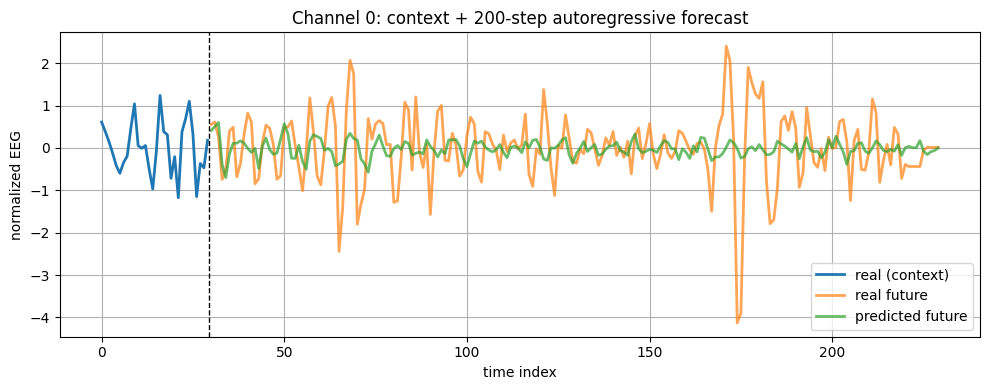

In [759]:
G.eval()

steps_ahead = 200
ch = 0  # channel index
L = seq_len
H = steps_ahead

T = obs_x.shape[0]
t0 = T - H # forecast start index
hist_start = t0 - L
hist_end = t0

ctx_x_np = obs_x[hist_start:hist_end] # (L, x_dim)
ctx_g_np = gamma_g[hist_start:hist_end] # (L, g_dim)
real_future_np = obs_x[t0:t0+H] # (H, x_dim)

ctx_x = torch.from_numpy(ctx_x_np).unsqueeze(0).to(device)
ctx_g = torch.from_numpy(ctx_g_np).unsqueeze(0).to(device)

#generated future
gen_future = []

with torch.no_grad():
    last_gamma = ctx_g[:, -1:, :] # simple choice for gamma
    for k in range(H):
        z = torch.randn(1, noise_dim, device=device)
        y_hat = G(z, ctx_x, ctx_g)

        gen_future.append(y_hat.cpu().numpy()[0])

        # slide window: drop oldest, append generated x_t
        ctx_x = torch.cat([ctx_x[:, 1:, :], y_hat.unsqueeze(1)], dim=1)
        ctx_g = torch.cat([ctx_g[:, 1:, :], last_gamma], dim=1)

gen_future = np.stack(gen_future, axis=0) # (H, x_dim)

# plotting one channel
real_hist = ctx_x_np[:, ch]
real_fut = real_future_np[:, ch]
pred_fut = gen_future[:, ch]

t_hist = np.arange(L)
t_fut  = np.arange(L, L+H)

plt.figure(figsize=(10,4))
plt.plot(t_hist, real_hist, label="real (context)", linewidth=2)
plt.plot(t_fut, real_fut,  label="real future", linewidth=2, alpha=0.7)
plt.plot(t_fut, pred_fut,  label="predicted future", linewidth=2, alpha=0.7)
plt.axvline(x=L-0.5, color="k", linestyle="--", linewidth=1)
plt.xlabel("time index")
plt.ylabel("normalized EEG")
plt.title(f"Channel {ch}: context + {H}-step autoregressive forecast")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
